In [ ]:
# imports
import os, random, gc, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score,
                             roc_curve, auc)
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample

import torch
from transformers import AutoTokenizer, AutoModel
import torchS
import torch.nn as nn

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
# load CSV (adjust path if needed)
train = pd.read_csv("D:\ML_Projects\KBJ - CyberThreat\data\cyber-threat-intelligence-splited_train.csv")
val   = pd.read_csv("D:\ML_Projects\KBJ - CyberThreat\data\cyber-threat-intelligence-splited_validate.csv")
test  = pd.read_csv("D:\ML_Projects\KBJ - CyberThreat\data\cyber-threat-intelligence-splited_test.csv")

print("=== SHAPE ===")
print("Train:", train.shape)
print("Val  :", val.shape)
print("Test :", test.shape)
print("\n=== COLUMNS ===")
print(train.columns)

# show table (first 10 rows)
display(train.head(10))


=== SHAPE ===
Train: (6812, 10)
Val  : (1460, 10)
Test : (1460, 10)

=== COLUMNS ===
Index(['Unnamed: 0', 'index', 'text', 'entities', 'relations', 'Comments',
       'id', 'label', 'start_offset', 'end_offset'],
      dtype='object')


,Unnamed: 0,index,text,entities,relations,Comments,id,label,start_offset,end_offset
0,0,11709,"Malicious version of My First APP, which adds ...","[{'id': 36090, 'label': 'malware', 'start_offs...",[],[],36090.0,malware,46.0,56.0
1,1,4382,HYPERSCRAPE demonstrates Charming Kitten’s com...,"[{'id': 13145, 'label': 'threat-actor', 'start...",[],[],13145.0,threat-actor,25.0,40.0
2,2,12581,This looked similar to an earlier in-the-wild ...,[],[],[],NaN,NaN,NaN,NaN
3,3,11292,We need to request that a download link be gen...,[],[],[],NaN,NaN,NaN,NaN
4,4,13494,"Some malicious actors, such as ransomware oper...",[],[],[],NaN,NaN,NaN,NaN
5,5,5386,We have evidence that the routers of at least ...,"[{'id': 51380, 'label': 'malware', 'start_offs...",[],[],51380.0,malware,106.0,119.0
6,6,3889,They should also exercise an incident response...,[],[],[],NaN,NaN,NaN,NaN
7,7,7302,It collects the following information from the...,[],[],[],NaN,NaN,NaN,NaN
8,8,14275,...,[],[],[],NaN,NaN,NaN,NaN
9,9,3040,Many apps these days have auto-update capabili...,[],[],[],NaN,NaN,NaN,NaN


In [21]:
# Best-effort mapping — edit if you want different grouping
ATTACK_LABELS = {
    'malware','attack-pattern','threat-actor','vulnerability','campaign',
    'Infrastucture','tools','exploit','ransomware'  # add more if present
}

# Normalize labels to lower-case for safe matching
def map_to_binary(lbl):
    if pd.isna(lbl): return np.nan
    l = str(lbl).strip().lower()
    return 1 if l in set([x.lower() for x in ATTACK_LABELS]) else 0

# apply mapping
train['binary_label'] = train['label'].apply(map_to_binary)
val['binary_label']   = val['label'].apply(map_to_binary)
test['binary_label']  = test['label'].apply(map_to_binary)

# If mapping produced NaN (unknown), fill those as NON-ATTACK (0) or handle separately.
# Here we treat unknowns as NON-ATTACK to be conservative.
train['binary_label'] = train['binary_label'].fillna(0).astype(int)
val['binary_label']   = val['binary_label'].fillna(0).astype(int)
test['binary_label']  = test['binary_label'].fillna(0).astype(int)

# show distribution
print("=== LABEL DISTRIBUTION (TRAIN) ===")
print(train['binary_label'].value_counts())
print("\nSample rows:")
display(train.sample(6, random_state=SEED))


=== LABEL DISTRIBUTION (TRAIN) ===
binary_label
0    5214
1    1598
Name: count, dtype: int64

Sample rows:


,Unnamed: 0,index,text,entities,relations,Comments,id,label,start_offset,end_offset,binary_label
4110,4110,1461,Figure 2,[],[],[],NaN,NaN,NaN,NaN,0
2941,2941,12686,"For a period of time, we observed thousands of...","[{'id': 39368, 'label': 'location', 'start_off...",[],[],39368.0,location,16.0,20.0,0
1370,1370,13516,Consider using dedicated two-factor authentica...,[],[],[],NaN,NaN,NaN,NaN,0
2405,2405,14239,The repository for Winnti’s C&C communications...,"[{'id': 48431, 'label': 'identity', 'start_off...",[],[],48431.0,identity,19.0,25.0,0
6509,6509,10652,As organizations reeled from the Log4Shell vul...,"[{'id': 32519, 'label': 'attack-pattern', 'sta...",[],[],32519.0,attack-pattern,103.0,109.0,1
4213,4213,8078,Bytes: 30 0D 06 09 2A 86 48 86 F7 0D 01 01 0B...,[],[],[],NaN,NaN,NaN,NaN,0


In [22]:
# separate classes
df_majority = train[train.binary_label==0]
df_minority = train[train.binary_label==1]

print("Before resample: ", train['binary_label'].value_counts().to_dict())

# if minority class is 0 (no attacks), guard
if len(df_minority)==0:
    raise RuntimeError("No samples mapped to ATTACK (1). Update ATTACK_LABELS mapping!")

# undersample majority to minority size (or to some multiplier if desired)
n_min = len(df_minority)
df_majority_downsampled = df_majority.sample(n=n_min, random_state=SEED)

train_balanced = pd.concat([df_minority, df_majority_downsampled]).sample(frac=1, random_state=SEED).reset_index(drop=True)
print("After resample (TRAIN balanced): \n", train_balanced['binary_label'].value_counts().to_dict())


Before resample:  {0: 5214, 1: 1598}
After resample (TRAIN balanced): 
 {0: 1598, 1: 1598}


In [23]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


CUDA Available: True
GPU Name: NVIDIA GeForce RTX 2050


In [ ]:
# 1. Load tokenizer + model BERT (PyTorch)
MODEL_NAME = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME)

# Tambahkan sebelum bagian encode_texts
y_train = train_balanced["binary_label"]  # gunakan train_balanced yang sudah seimbang
y_val   = val["binary_label"]

# 2. Encoding text (fungsi tetap sama)
def encode_texts(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"   # <= PENTING: pakai PyTorch
    )

In [25]:
# 3. BERT Classification Head (PyTorch Module)

class BertClassifier(nn.Module):
    def __init__(self, dropout=0.2):
        super(BertClassifier, self).__init__()

        self.bert = bert_model
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0, :]  # ambil CLS

        x = self.dropout(cls_token)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


In [26]:
# Clear GPU cache setelah training
torch.cuda.empty_cache()
gc.collect()

5945

In [27]:
# ==========================================================
# 4. Train BERT dengan PyTorch (batched, hemat VRAM)
# ==========================================================

from torch.utils.data import TensorDataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Tensor label
y_train = torch.tensor(train_balanced["binary_label"].values).float()
y_val   = torch.tensor(val["binary_label"].values).float()

# Encode teks (tetap di CPU, akan dipindah batch per batch)
train_enc = encode_texts(train_balanced["text"].tolist())
val_enc   = encode_texts(val["text"].tolist())

# Buat Dataset & DataLoader
train_dataset = TensorDataset(train_enc["input_ids"], train_enc["attention_mask"], y_train)
train_loader  = DataLoader(train_dataset, batch_size=8, shuffle=False)  # batch kecil

val_dataset   = TensorDataset(val_enc["input_ids"], val_enc["attention_mask"], y_val)
val_loader    = DataLoader(val_dataset, batch_size=8)

# Model, loss, optimizer
model = BertClassifier().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

EPOCHS = 3

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_loss:.4f}")

    # ===== Validation =====
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = (outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    print(f"            Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}\n")

# Clear GPU cache setelah training
torch.cuda.empty_cache()
gc.collect()

Using device: cuda
Epoch 1/3 - Train Loss: 0.5423
            Val Loss: 0.4483 | Val Acc: 0.8041

Epoch 2/3 - Train Loss: 0.3438
            Val Loss: 0.4975 | Val Acc: 0.8007

Epoch 3/3 - Train Loss: 0.2037
            Val Loss: 0.5281 | Val Acc: 0.8240



8

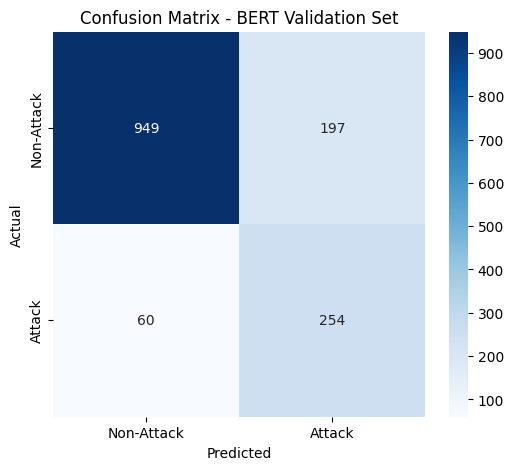

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ===== Predict on validation set =====
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)
        preds = (outputs >= 0.5).long()  # threshold 0.5
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ===== Confusion Matrix =====
cm = confusion_matrix(all_labels, all_preds)
classes = ["Non-Attack", "Attack"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - BERT Validation Set")
plt.show()


In [ ]:
import torch
import numpy as np
import time
from transformers import AutoTokenizer, AutoModel

# -----------------------------
# 1. Setup Model & Device
# -----------------------------
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"  
MAX_LEN = 128
BATCH_SIZE = 64  # GPU kamu harus kuat untuk 64, kalau OOM turunin ke 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
embedding_model = AutoModel.from_pretrained(MODEL_NAME).to(device)
embedding_model.eval()

# -----------------------------
# 2. Embedding Function
# -----------------------------
def embed_texts(texts, batch_size=BATCH_SIZE, max_len=MAX_LEN):
    all_emb = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=max_len,
                return_tensors='pt'
            ).to(device)

            # GANTI DI SINI JUGA
            out = embedding_model(**enc)

            attn = enc['attention_mask'].unsqueeze(-1).expand(out.last_hidden_state.size()).float()
            pooled = torch.sum(out.last_hidden_state * attn, dim=1) / torch.clamp(attn.sum(dim=1), min=1e-9)
            all_emb.append(pooled.cpu().numpy())

    return np.vstack(all_emb)

# -----------------------------
# 3. Generate Embeddings
# -----------------------------
t0 = time.time()
X_train = embed_texts(train_balanced['text'].tolist())
X_val   = embed_texts(val['text'].tolist())
X_test  = embed_texts(test['text'].tolist())
t1 = time.time()

print(f"Done in {t1 - t0:.1f}s")
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

print("Embedding selesai. Membersihkan VRAM...")
del embedding_model
del tokenizer
torch.cuda.empty_cache()
gc.collect()
print("VRAM bersih. Siap untuk Training RF/XGBoost.")


Using device: cuda
Done in 8.1s
Shapes: (3196, 384) (1460, 384) (1460, 384)


In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import geometric_mean_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import pandas as pd

def evaluate(model, x, y):
    pred = model.predict(x)
    proba = model.predict_proba(x)[:,1] if hasattr(model, "predict_proba") else None
    
    metrics = {
        "Accuracy": accuracy_score(y, pred),
        "Precision": precision_score(y, pred),
        "Recall": recall_score(y, pred),
        "F1": f1_score(y, pred),
        "G-Mean": geometric_mean_score(y, pred),
        "ROC-AUC": roc_auc_score(y, proba) if proba is not None else None
    }
    return metrics


# ================================
# 1. RANDOM FOREST
# ================================
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

rf_metrics = evaluate(rf, X_val, y_val)
print("Random Forest:", rf_metrics)


# ================================
# 2. SVM (probability enabled)
# ================================
svm = SVC(
    kernel='rbf',
    probability=True,
    class_weight='balanced',
    random_state=42
)
svm.fit(X_train, y_train)

svm_metrics = evaluate(svm, X_val, y_val)
print("SVM:", svm_metrics)


# ================================
# 3. XGBOOST
# ================================
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',   # fast for CPU
    random_state=42
)
xgb.fit(X_train, y_train)

xgb_metrics = evaluate(xgb, X_val, y_val)
print("XGBoost:", xgb_metrics)


# ================================
# SUMMARY TABLE
# ================================
df_results = pd.DataFrame({
    "Random Forest": rf_metrics,
    "SVM": svm_metrics,
    "XGBoost": xgb_metrics
})

df_results


Random Forest: {'Accuracy': 0.7705479452054794, 'Precision': 0.47878787878787876, 'Recall': 0.7547770700636943, 'F1': 0.5859085290482077, 'G-Mean': np.float64(0.7647571094727694), 'ROC-AUC': 0.8453357566056403}
SVM: {'Accuracy': 0.7945205479452054, 'Precision': 0.5141129032258065, 'Recall': 0.8121019108280255, 'F1': 0.6296296296296297, 'G-Mean': np.float64(0.8008243077070357), 'ROC-AUC': 0.8690654839319261}
XGBoost: {'Accuracy': 0.7780821917808219, 'Precision': 0.49038461538461536, 'Recall': 0.8121019108280255, 'F1': 0.6115107913669064, 'G-Mean': np.float64(0.7901342936198759), 'ROC-AUC': 0.8574076544280299}


,Random Forest,SVM,XGBoost
Accuracy,0.770548,0.794521,0.778082
Precision,0.478788,0.514113,0.490385
Recall,0.754777,0.812102,0.812102
F1,0.585909,0.629630,0.611511
G-Mean,0.764757,0.800824,0.790134
ROC-AUC,0.845336,0.869065,0.857408


In [31]:
# --- REVISI UNTUK BAGIAN FINAL METRICS (PASTE DI BAWAH XGBOOST) ---

print("Menghitung Metrics Final BERT untuk Tabel Perbandingan...")

# 1. Pastikan jangan panggil BertClassifier() lagi. Gunakan 'model' yang sudah dilatih di atas.
model.eval()

# 2. Siapkan list kosong
all_preds_bert_final = []
all_labels_bert_final = []

# 3. Loop Prediksi (Pakai val_loader yang sama dengan saat training)
with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)
        preds = (outputs >= 0.5).long()

        # Simpan
        all_preds_bert_final.extend(preds.cpu().numpy())
        all_labels_bert_final.extend(labels.cpu().numpy())

# 4. Hitung Metrics Final
bert_metrics = {
    "Accuracy": accuracy_score(all_labels_bert_final, all_preds_bert_final),
    "Precision": precision_score(all_labels_bert_final, all_preds_bert_final),
    "Recall": recall_score(all_labels_bert_final, all_preds_bert_final),
    "F1": f1_score(all_labels_bert_final, all_preds_bert_final)
}

print("BERT Metrics Updated:", bert_metrics)

# Setelah ini baru lanjut ke pembuatan DataFrame df_compare_table...

Menghitung Metrics Final BERT untuk Tabel Perbandingan...
BERT Metrics Updated: {'Accuracy': 0.8239726027397261, 'Precision': 0.5631929046563193, 'Recall': 0.8089171974522293, 'F1': 0.6640522875816993}


In [32]:
import pandas as pd

# Metrics yang mau ditampilkan
metrics_names = ["Accuracy", "Precision", "Recall", "F1"]

# Buat DataFrame perbandingan
df_compare_table = pd.DataFrame({
    "Random Forest": [rf_metrics[m] for m in metrics_names],
    "SVM": [svm_metrics[m] for m in metrics_names],
    "XGBoost": [xgb_metrics[m] for m in metrics_names],
    "BERT": [bert_metrics[m] for m in metrics_names]
}, index=metrics_names)

# Tampilkan tabel
display(df_compare_table)


,Random Forest,SVM,XGBoost,BERT
Accuracy,0.770548,0.794521,0.778082,0.823973
Precision,0.478788,0.514113,0.490385,0.563193
Recall,0.754777,0.812102,0.812102,0.808917
F1,0.585909,0.629630,0.611511,0.664052
